# Filtro de Kalman

Vamos a entender las bases del filtro de Kalman a partir de trabajar con gaussianas.

En Kalman, tanto las creencias como las mediciones son gaussianas.

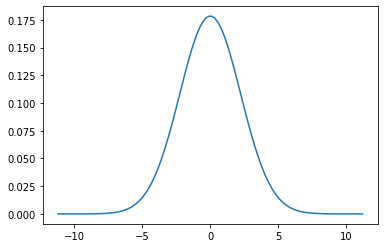

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import random
import matplotlib.mlab as mlab
import math
import scipy.stats

# Una gaussiana queda totalmente definida por su primer y segundo momento:
mu = 0
variance = 5

sigma = math.sqrt(variance)
x = np.linspace(mu - 5*sigma, mu + 5*sigma, 100)
plt.plot(x,scipy.stats.norm.pdf(x, mu, sigma))
plt.show()

## ¿Por qué Gaussianas?

El robot suele confiar su localización a una gran cantidad de robots. Cuando se realiza un seguimiento de la localización, normalmente el robot sabe aproximadamente donde se encuentra al empezar a localizarse, eso provoca que la creencia inicial pueda ser unimodal y generalmente se utilizan gaussians. Además, al realizar mediciones para ajustar la esimación del robot normalmente se usan muchos sensores, eso provoca la necesidad de hacer una fusión de las mediciones. En la fusión de los sensores, las distribuciones (por Teorema Central del Limite) pueden aproximarse a las de una gaussiana. Entonces tanto las entradas asociadas al movimiento, como las entradas por mediciones son gaussianas.

## Actualización por movimiento (Predicción)

Si conozco mi posición inicial con una cierta incertidumbre y me muevo hacia una nueva posición (en este movimiento también hay incertidumbre), la posición final será la suma de la media inicial y la cantidad que me moví, junto con toda la incertidumbre acumulada.


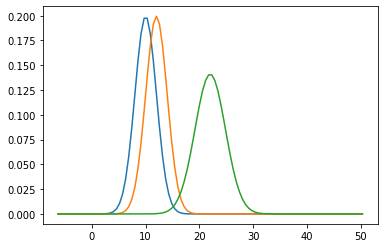

In [17]:
## Función de predicción

def predict(mean1, var1, mean2, var2):
  new_mean = mean1 + mean2
  new_var = var1 + var2
  return [new_mean,new_var]

mean1 = 10
var1 = 4
mean2 = 12
var2 = 4
new_mean, new_var = predict(mean1, var1, mean2, var2)

x = np.linspace(new_mean - 10*math.sqrt(new_var), new_mean + 10*math.sqrt(new_var), 100)

plt.plot(x,scipy.stats.norm.pdf(x, mean1, math.sqrt(var1)),x,scipy.stats.norm.pdf(x, mean2, math.sqrt(var2)),x,scipy.stats.norm.pdf(x, new_mean, math.sqrt(new_var)))
plt.show()



## Actualización por medición

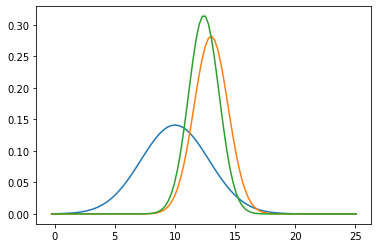

In [18]:
def measure(mean1, var1, mean2, var2):
    new_mean = (var2*mean1+var1*mean2)/(var1+var2)
    new_var = 1/(1/var1+1/var2)
    return [new_mean, new_var]

mean1 = 10
var1 = 8
mean2 = 13
var2 = 2
new_mean, new_var = measure(mean1, var1, mean2, var2)

x = np.linspace(new_mean - 10*math.sqrt(new_var), new_mean + 10*math.sqrt(new_var), 100)

plt.plot(x,scipy.stats.norm.pdf(x, mean1, math.sqrt(var1)),x,scipy.stats.norm.pdf(x, mean2, math.sqrt(var2)),x,scipy.stats.norm.pdf(x, new_mean, math.sqrt(new_var)))
plt.show()

## Función del filtro de Kalman

update:  [0.9615384615384616, 3.846153846153846]
predict:  [2.9615384615384617, 5.846153846153846]


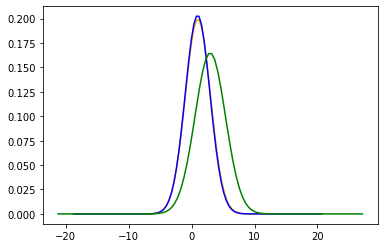

update:  [2.9843749999999996, 2.375]
predict:  [4.984375, 4.375]


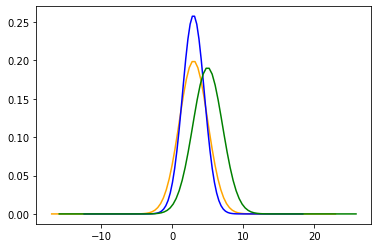

update:  [4.992537313432836, 2.0895522388059704]
predict:  [9.992537313432836, 4.08955223880597]


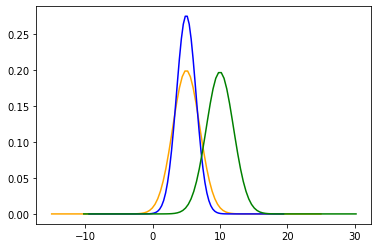

update:  [9.99630996309963, 2.022140221402214]
predict:  [12.99630996309963, 4.022140221402214]


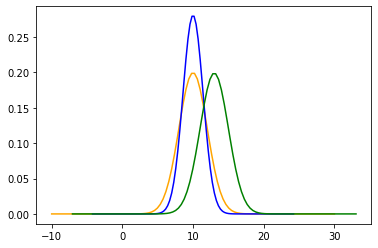

update:  [12.998160073597056, 2.0055197792088317]
predict:  [16.998160073597056, 4.005519779208832]


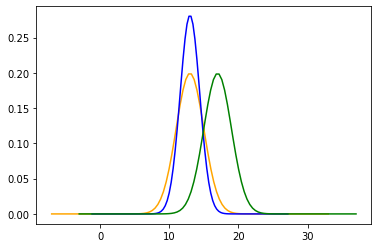

In [45]:
# Escribir un programa que actualice iterativamente la medición y la predicción
def measure(mean1, var1, mean2, var2):
    new_mean = float(var2 * mean1 + var1 * mean2) / (var1 + var2)
    new_var = 1./(1./var1 + 1./var2)
    return [new_mean, new_var]

def predict(mean1, var1, mean2, var2):
    new_mean = mean1 + mean2
    new_var = var1 + var2
    return [new_mean, new_var]

measurements = [1., 3., 5., 10., 13.]  # Valores medios arrojados por las mediciones
motion = [2., 2., 5., 3., 4.]  # Valores medios de los movimientos
measurement_sig = 4.  # incertidumbre en la medición
motion_sig = 2.  # Incertidumbre en el movimiento
mu = 0.  # Posición inicial del robot
sig = 100.  # Certeza sobre la posición

# x = np.linspace(mu - 10*math.sqrt(sig), mu + 10*math.sqrt(sig), 100)
# plt.plot(x,scipy.stats.norm.pdf(x, mu, math.sqrt(sig)))
# plt.show()
mu_list=[mu]
var_list=[sig]
for i in range(len(measurements)):
  next_mu, next_var = measure(mu_list[-1],var_list[-1],measurements[i],measurement_sig)
  mu_list.append(next_mu)
  var_list.append(next_var)
  print('update: ', [next_mu,next_var])
  plt.figure()
  x = np.linspace(measurements[i] - 10*math.sqrt(measurement_sig), measurements[i] + 10*math.sqrt(measurement_sig), 100)
  plt.plot(x,scipy.stats.norm.pdf(x, measurements[i], math.sqrt(measurement_sig)), color='orange')
  x = np.linspace(next_mu - 10*math.sqrt(next_var), next_mu + 10*math.sqrt(next_var), 100)
  plt.plot(x,scipy.stats.norm.pdf(x, next_mu, math.sqrt(next_var)),color='blue')
  
  next_mu, next_var = predict(mu_list[-1],var_list[-1],motion[i],motion_sig)
  mu_list.append(next_mu)
  var_list.append(next_var)
  print('predict: ', [next_mu,next_var])
  
  x = np.linspace(next_mu - 10*math.sqrt(next_var), next_mu + 10*math.sqrt(next_var), 100)
  plt.plot(x,scipy.stats.norm.pdf(x, next_mu, math.sqrt(next_var)), color='green')
  plt.show()

# KF Multidimensional

In [ ]:
#NICO!
def kalman_filter(x, R):
    I = np.eye(x.shape[0])
    for n in range(len(measurements)):        
        # Paso 1. Medir y actualizar
        Z = measurements[n]   
        y = Z - H@x
        
        # Paso 2. Ganancia Kalman
        S = ((H@R)@H.T) + Q
        K = (R@H.T)*np.linalg.inv(S)

        # Paso 3. El próximo X c/ contribución de las mediciones
        x = x + (K*y)        
        R = (I - K@H)@R

  # Paso 4. Predicción de X y actualización de P
        x = F@x + u
        R = F@R@F.T
    return x,R

measurements = [1, 2, 3]

In [47]:
# Implementar el filtro de Kalman utilizando matrices

def kalman_filter(x, P, measurements, u, F, H ,R):
  for i in range(len(measurements)):
      # measurement update
      y = measurements[i] - (H @ x)
      S = ((H @ P) @ H.T)+ R
      K = (P @ H.T) @ np.linalg.inv(S)
      # estimation
      x = x + (K @ y)
      P = (np.identity(2) - (K @ H)) @ P
      # prediction
      x = (F @ x) + u
      P = (F @ P) @ F.T 
      print("------------------")
      print("x", x.T)
      print("P", P)
  return x,P

measurements = [1, 2, 3]

x = np.array([[0.], [0.]]) # estado inicial (posición y velocidad)
P = np.array([[1000., 0.], [0., 1000.]]) # Incertidumbre inicial
u = np.array([[0.], [0.]]) # movimiento externo
F = np.array([[1., 1.], [0, 1.]]) # matriz de estados
H = np.array([[1., 0.]]) # matriz de mediciones
R = np.array([[1.]]) # incertidumbre en la medición


ret_x, ret_P = kalman_filter(x, P, measurements, u, F, H ,R)
# la salida debería ser:
# x: [[3.9996664447958645], [0.9999998335552873]]
# P: [[2.3318904241194827, 0.9991676099921091], [0.9991676099921067, 0.49950058263974184]]


------------------
x [[0.999001 0.      ]]
P [[1000.999001 1000.      ]
 [1000.       1000.      ]]
------------------
x [[2.99800299 0.999002  ]]
P [[4.99002494 2.99301795]
 [2.99301795 1.99501297]]
------------------
x [[3.99966644 0.99999983]]
P [[2.33189042 0.99916761]
 [0.99916761 0.49950058]]


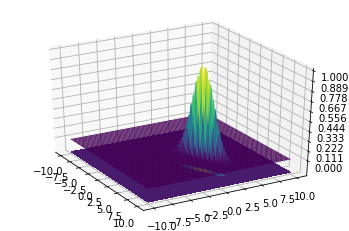

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

# Our 2-dimensional distribution will be over variables X and Y
N = 200
X = np.linspace(-10, 10, N)
Y = np.linspace(-10, 10, N)
X, Y = np.meshgrid(X, Y)

# # Mean vector and covariance matrix
# mu = np.array([0., 1.])
# Sigma = np.array([[ 1. , -0.5], [-0.5,  1.5]])
mu = np.array([[4, 1]]) 
Sigma = np.array([[2.3, 1], [1, 0.5]])

# Pack X and Y into a single 3-dimensional array
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

def multivariate_gaussian(pos, mu, Sigma):
    """Return the multivariate Gaussian distribution on array pos.

    pos is an array constructed by packing the meshed arrays of variables
    x_1, x_2, x_3, ..., x_k into its _last_ dimension.

    """
    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    N = np.sqrt((2*np.pi)**n * Sigma_det)
    # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
    # way across all the input variables.
    fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)

    return np.exp(-fac / 2) / N

# The distribution on the variables X, Y packed into pos.
Z = multivariate_gaussian(pos, mu, Sigma)

# Create a surface plot and projected filled contour plot under it.
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, Z, rstride=3, cstride=3, linewidth=1, antialiased=True,
                cmap=cm.viridis)

cset = ax.contourf(X, Y, Z, zdir='z', offset=-0.15, cmap=cm.viridis)

# Adjust the limits, ticks and view angle
ax.set_zlim(-0.15,1)
ax.set_zticks(np.linspace(0,1,10))
ax.view_init(30, -30)

plt.show()
